# Finding Lane Lines on the Road
***

In this project, I used Python and OpenCV to find lane lines in the road images.  

The following techniques are used:

- Color Selection
- Canny Edge Detection
- Region of Interest Selection
- Hough Transform Line Detection

Finally, I applied all the techniques to process video clips to find lane lines in them.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Test Images

The following libraries are used.  `cv2` is for OpenCV.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The following `show_image` function is used to display images.

In [ ]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols

    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

Let's load and examine the test images.

In [ ]:
test_images = [plt.imread(path) for path in glob.glob('/content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/test_images/*.jpg')]

show_images(test_images)

Lines are in white or yellow.  A white lane is a series of alternating dots and short lines, which we need to detect as one line.

## Color Selection

### RGB Color Space

The images are loaded in RGB color space.  Let's try selecting only yellow and white colors in the images using the RGB channels.

Reference: [RGB Color Code Chart](http://www.rapidtables.com/web/color/RGB_Color.htm)

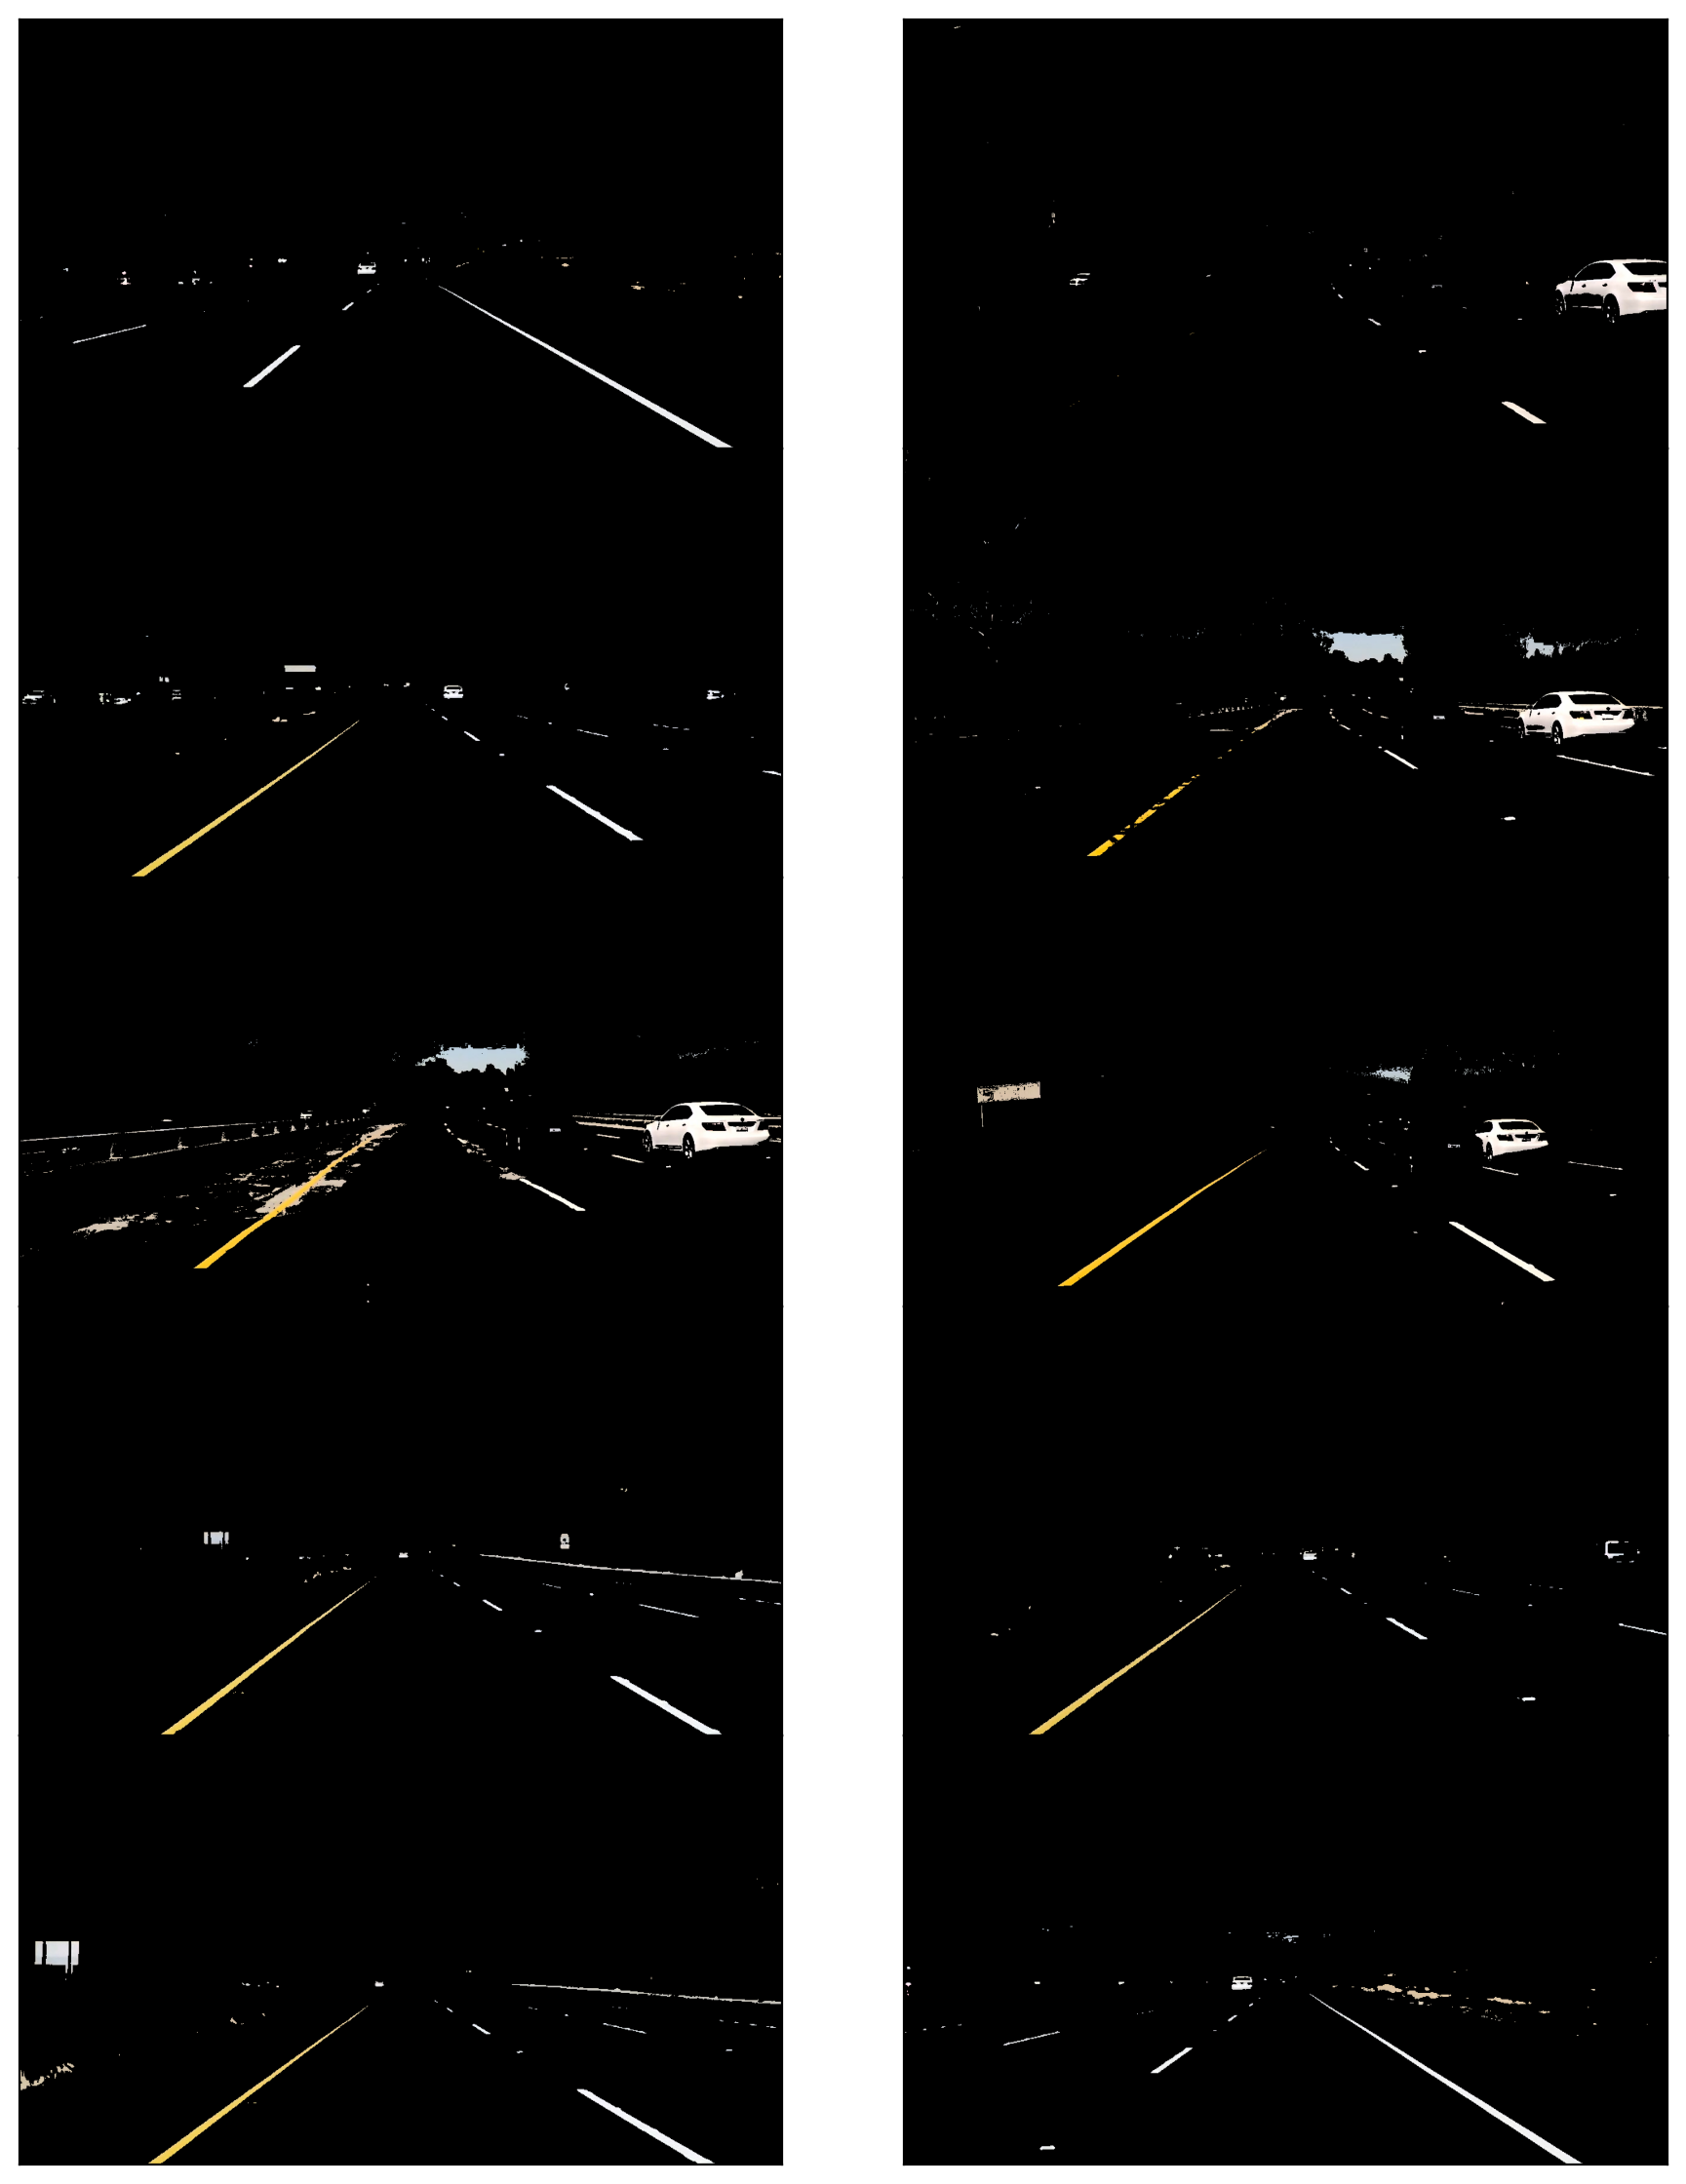

In [ ]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image):
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

show_images(list(map(select_rgb_white_yellow, test_images)))

It looks pretty good except the last two.  The yellow lines are not clear due to the dark shade from the tree on the left.

### HSV Color Space

How does it look when RGB images are converted into HSV color space?

In [ ]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, test_images)))

The yellow lines are very clear including the ones under the shades but the white lines are less clear.

### HSL Color Space

How does it look like when images are converted from RGB to HSL color space?

In [ ]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hls, test_images)))

Both the white and yellow lines are clearly recognizable.  Also, the yellow lines under the shades are clearly shown.

Let's build a filter to select those white and yellow lines.  I want to select particular range of each channels (Hue, Saturation and Light).

- Use `cv2.inRange` to filter the white color and the yellow color seperately.  
  The function returns 255 when the filter conditon is satisfied.  Otherwise, it returns 0.
- Use `cv2.bitwise_or` to combine these two binary masks.  
  The combined mask returns 255 when either white or yellow color is detected.
- Use `cv2.bitwise_and` to apply the combined mask onto the original RGB image

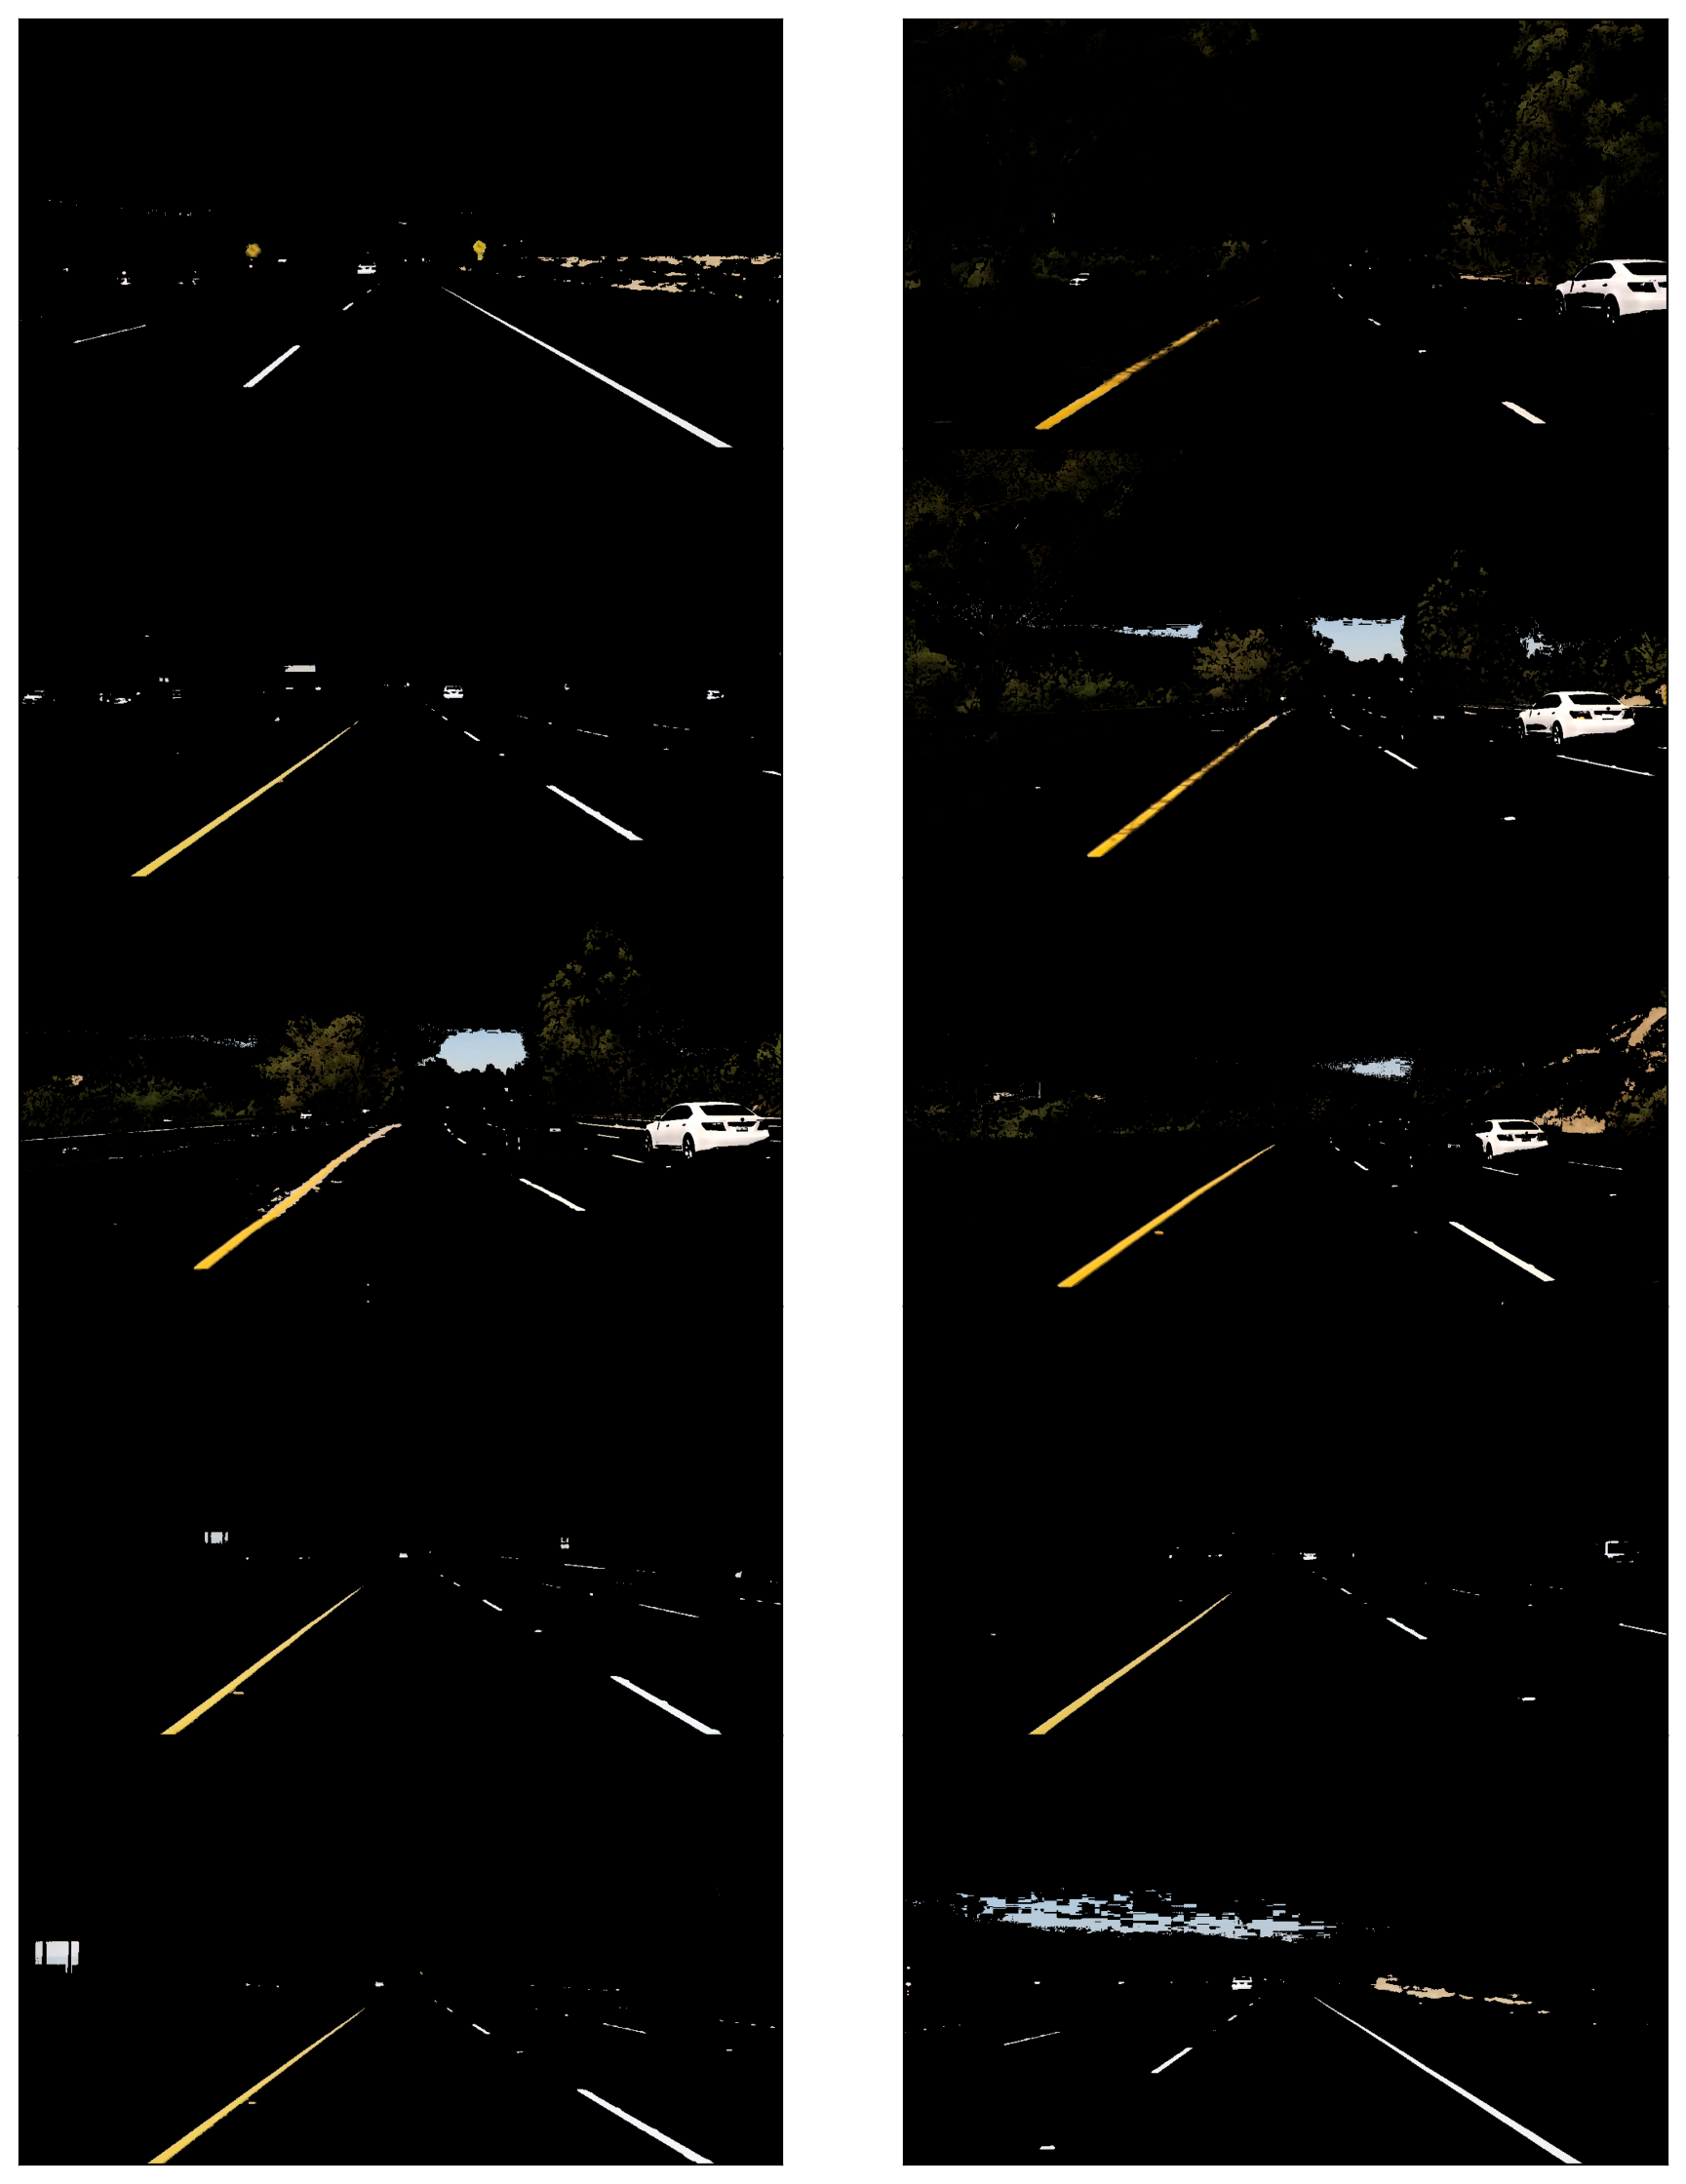

In [ ]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, test_images))

show_images(white_yellow_images)

For the white color,
- I chose high **Light** value.
- I did not filter **Hue**, **Saturation** values.
  
For the yellow color,
- I chose **Hue** around 30 to choose yellow color.
- I chose relatively high **Saturation** to exclude yellow hills

The combined mask filters the yellow and white lines very clearly.

## Canny Edge Detection

The Canny edge detector was developed by John F. Canny in 1986.  

We want to detect edges in order to find straight lines especially lane lines.  For this,

- use `cv2.cvtColor` to convert images into gray scale
- use `cv2.GaussianBlur` to smooth out rough edges
- use `cv2.Canny` to find edges

Let's take a look at each step in details.

Note: [Canny Edge Detection Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector) has a good description in good details.



### Gray Scaling

The images should be converted into gray scaled ones in order to detect shapes (edges) in the images.  This is because the Canny edge detection measures the magnitude of pixel intensity changes or gradients (more on this later).

Here, I'm converting the white and yellow line images from the above into gray scale for edge detection.

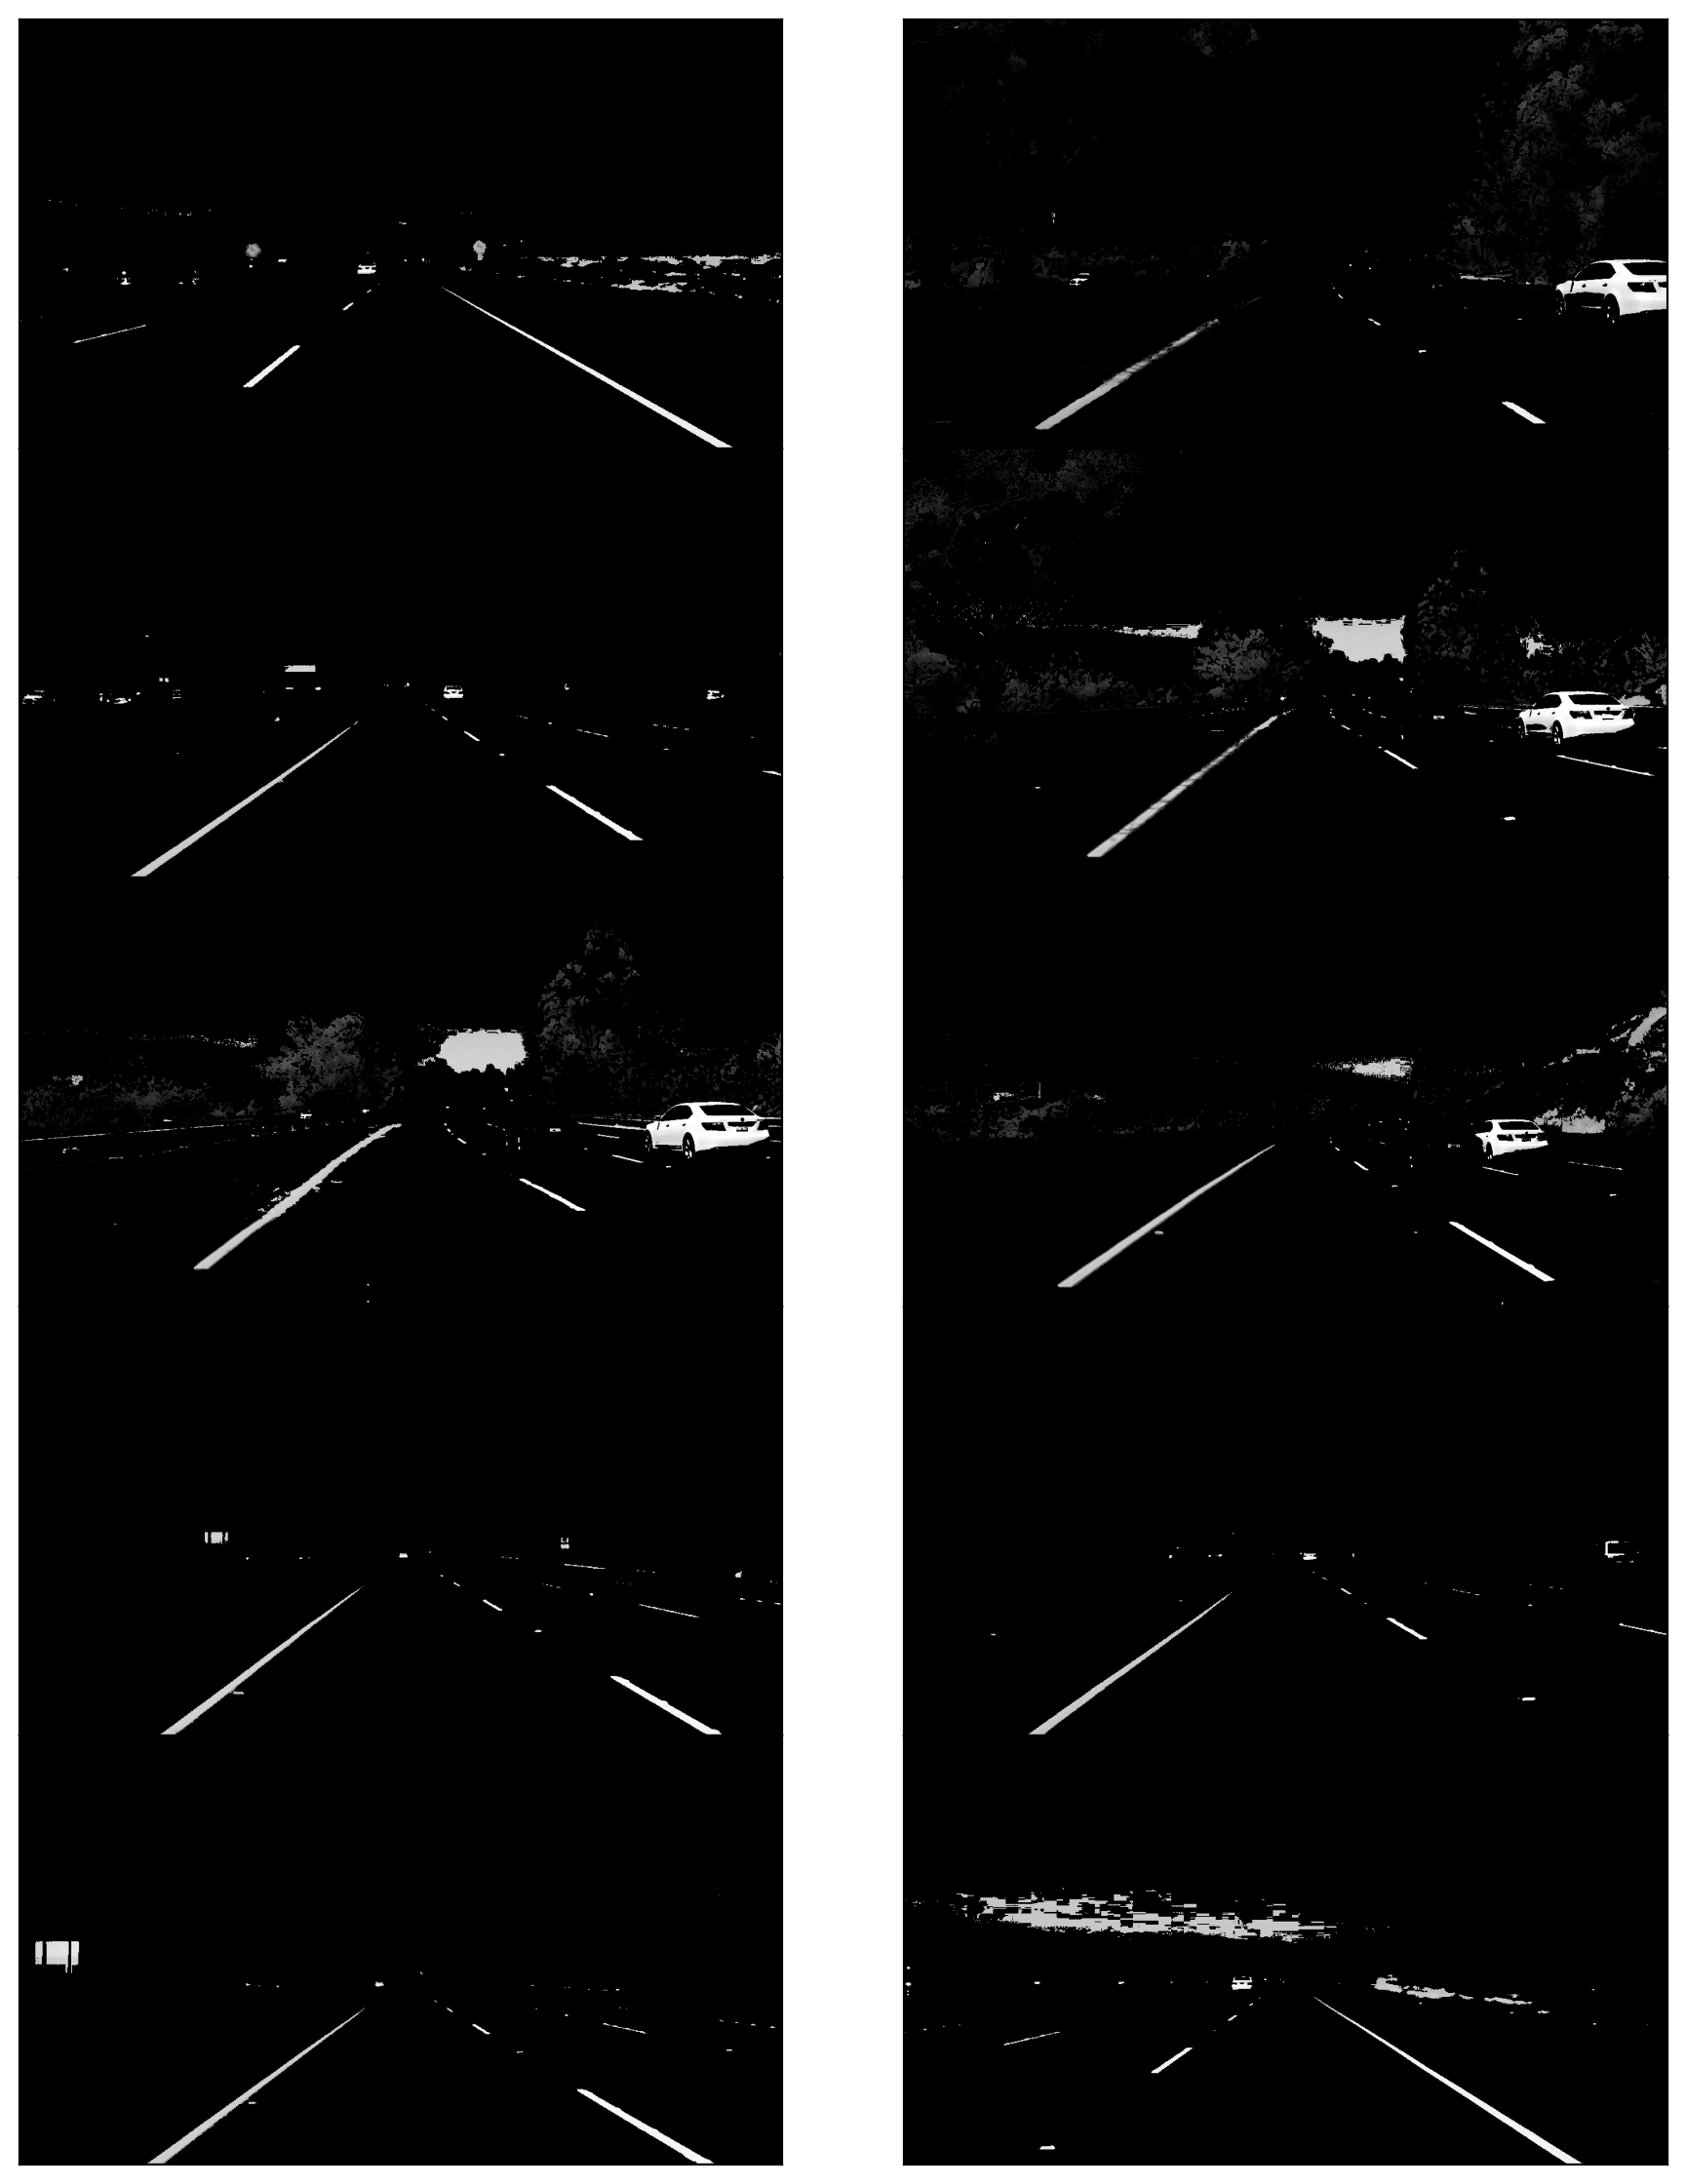

In [ ]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

### Gaussian Smoothing (Gaussian Blur)

When there is an edge (i.e. a line), the pixel intensity changes rapidly (i.e. from 0 to 255) which we want to detect.  But before doing so, we should make the edges smoother.  As you can see,  the above images have many rough edges which causes many noisy edges to be detected.

I use `cv2.GaussianBlur` to smooth out edges.

- [Gaussian Filter OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/gausian_median_blur_bilateral_filter/gausian_median_blur_bilateral_filter.html#gaussian-filter)
- [cv2.GaussianBlur OpenCV API Reference](http://docs.opencv.org/modules/imgproc/doc/filtering.html?highlight=gaussianblur#gaussianblur)

In [ ]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

The GaussianBlur takes a `kernel_size` parameter which you'll need to play with to find one that works best.  I tried 3, 5, 9, 11, 15, 17 (they must be positive and odd) and check the edge detection (see the next section) result.  The bigger the `kernel_size` value is,  the more blurry the image becomes.  

The bigger `kearnel_size` value requires more time to process. It is not noticeable with the test images but we should keep that in mind (later we'll be processing video clips).  So, we should prefer smaller values if the effect is similar.

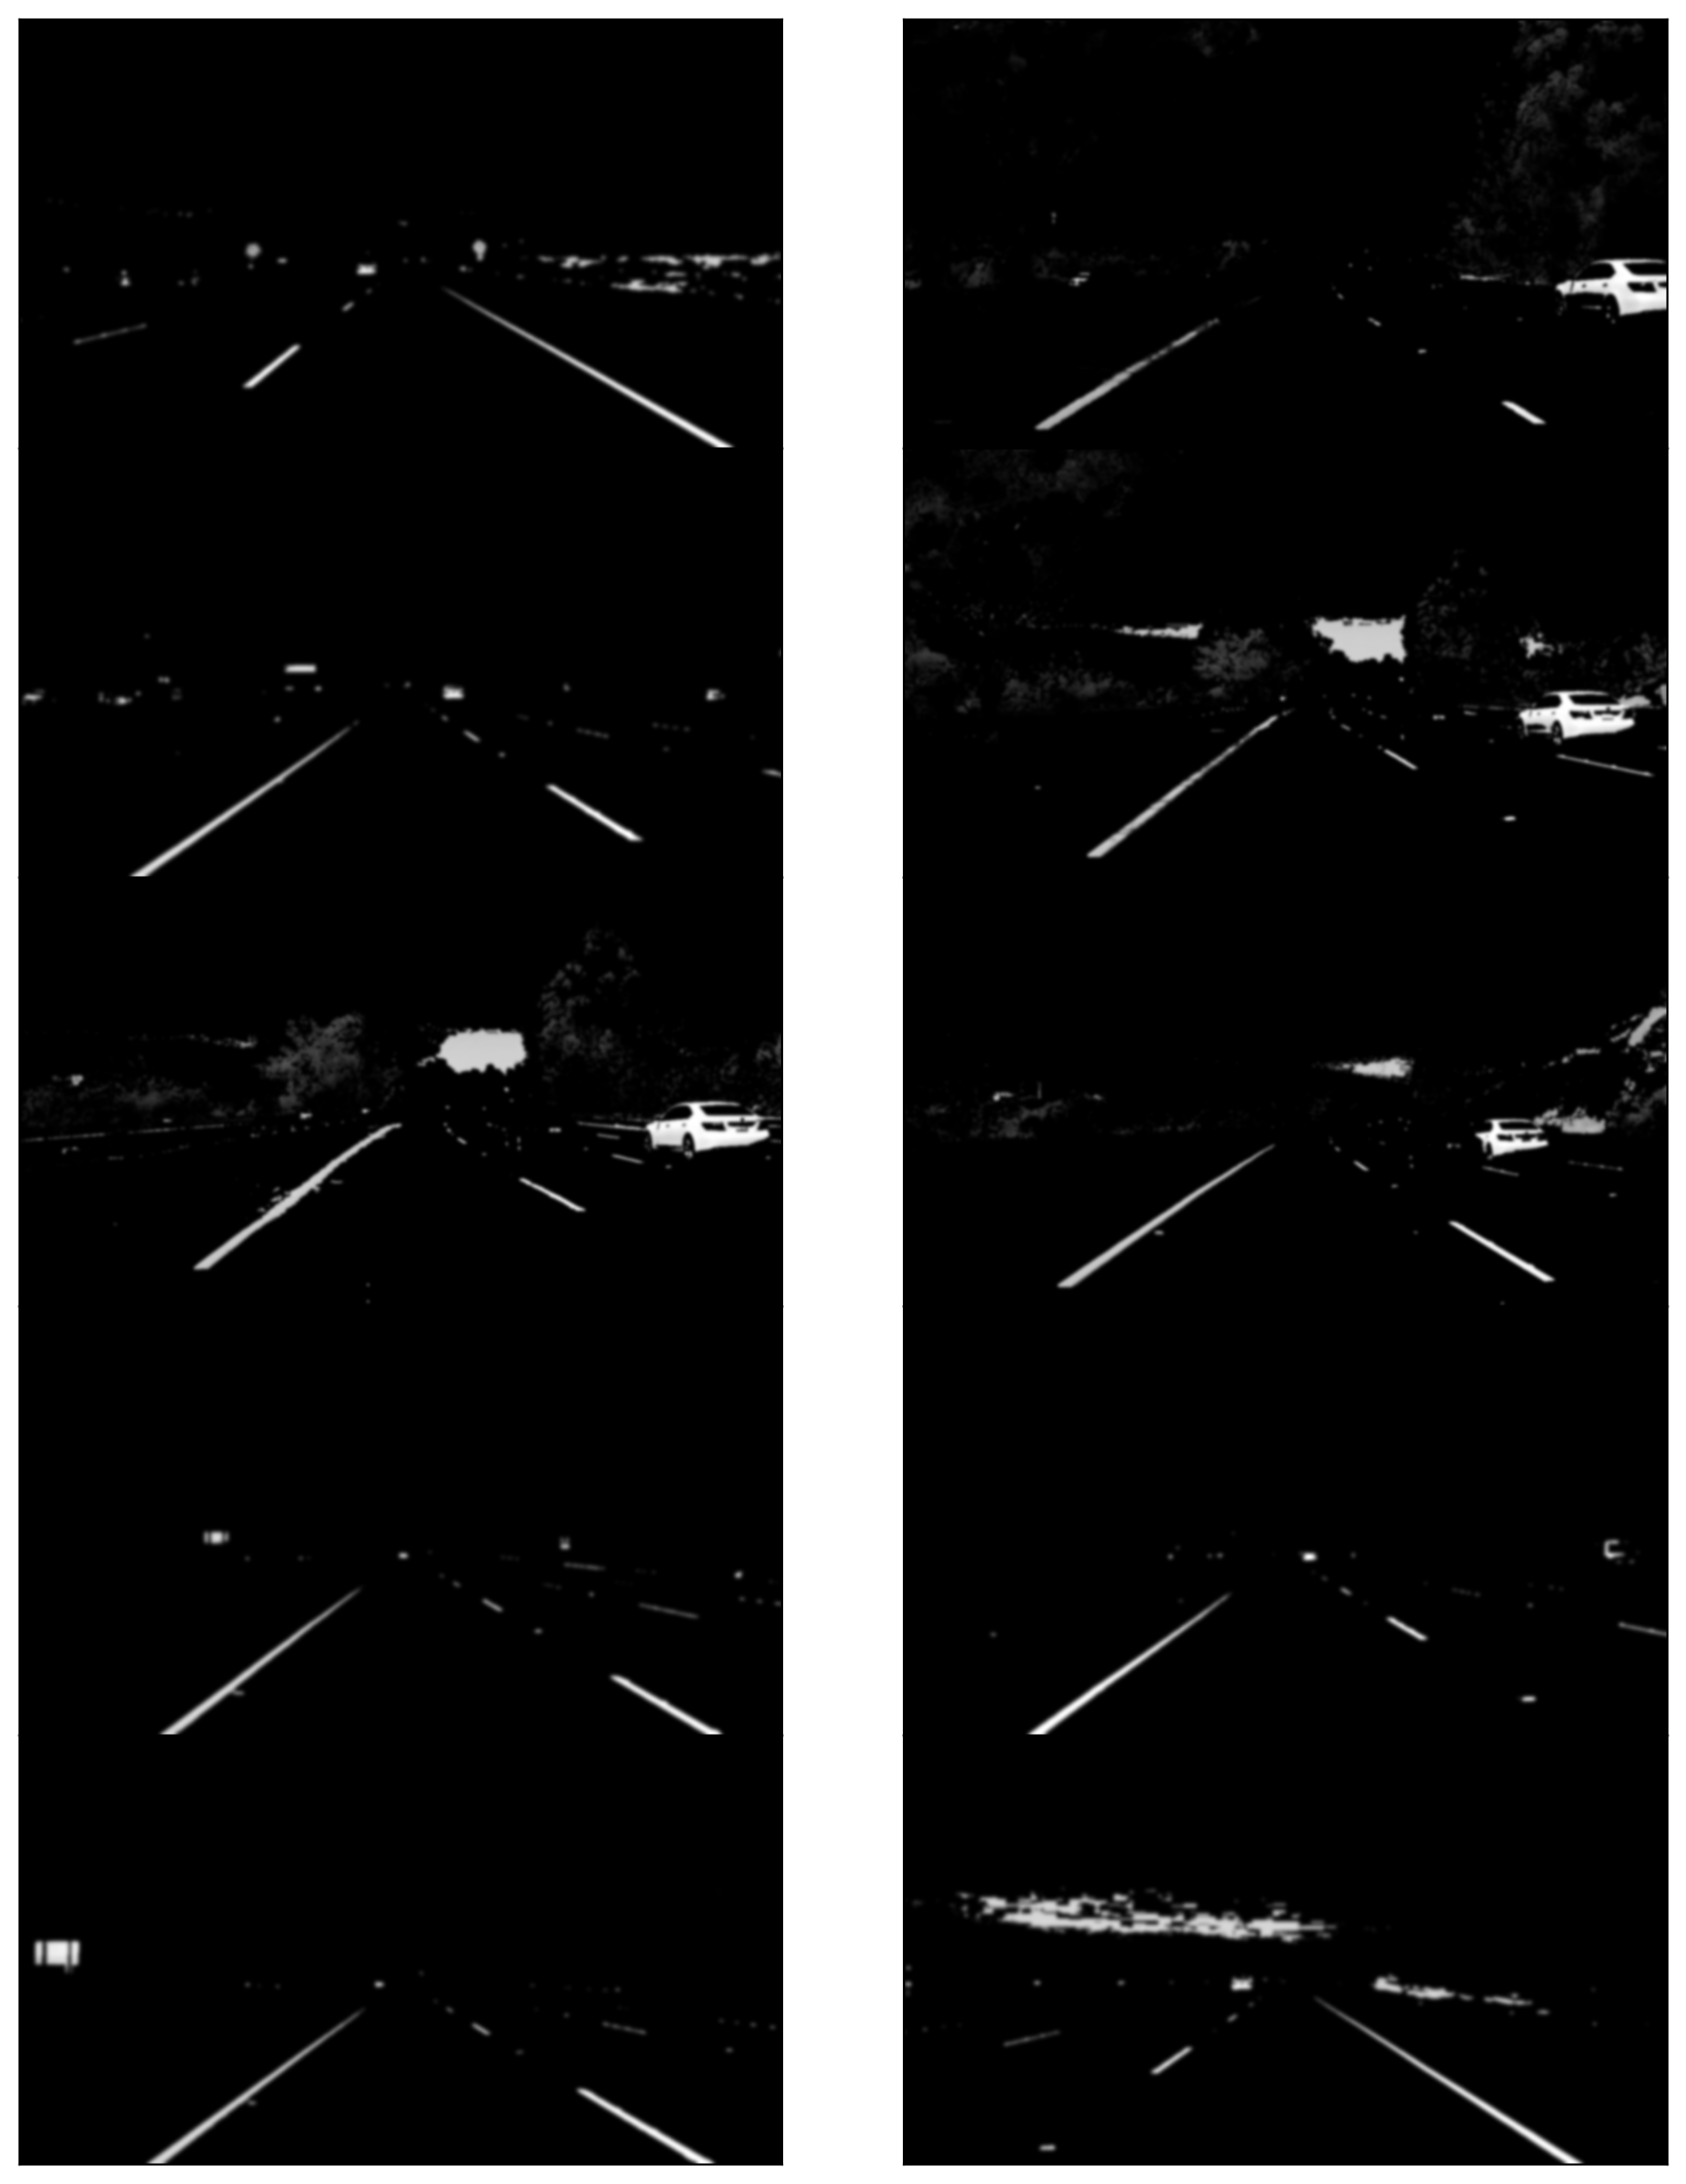

In [ ]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

### Edge Detection

`cv2.Canny` takes two threshold values which requires some explanation.

Wikipedia says:

> it is essential to filter out the edge pixel with the weak gradient value and preserve the edge with the high gradient value. Thus two threshold values are set to clarify the different types of edge pixels, one is called high threshold value and the other is called the low threshold value. If the edge pixel’s gradient value is higher than the high threshold value, they are marked as strong edge pixels. If the edge pixel’s gradient value is smaller than the high threshold value and larger than the low threshold value, they are marked as weak edge pixels. If the pixel value is smaller than the low threshold value, they will be suppressed.

According to the OpenCV documentation, the double thresholds are used as follows:

- If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
- If a pixel gradient value is below the lower threshold, then it is rejected.
- If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
- Canny recommended a upper:lower ratio between 2:1 and 3:1.

These two threshold values are empirically determined.  Basically, you will need to define them by trials and errors.

I first set the `low_threshold` to zero and then adjust the `high_threshold`.   If `high_threshold` is too high, you find no edges.  If `high_threshold` is too low, you find too many edges.  Once you find a good `high_threshold`, adjust the `low_threshold` to discard the weak edges (noises) connected to the strong edges.

- [Canny Edge Detection OpenCV Theory](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)
- [cv2.Canny OpenCV API Reference](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

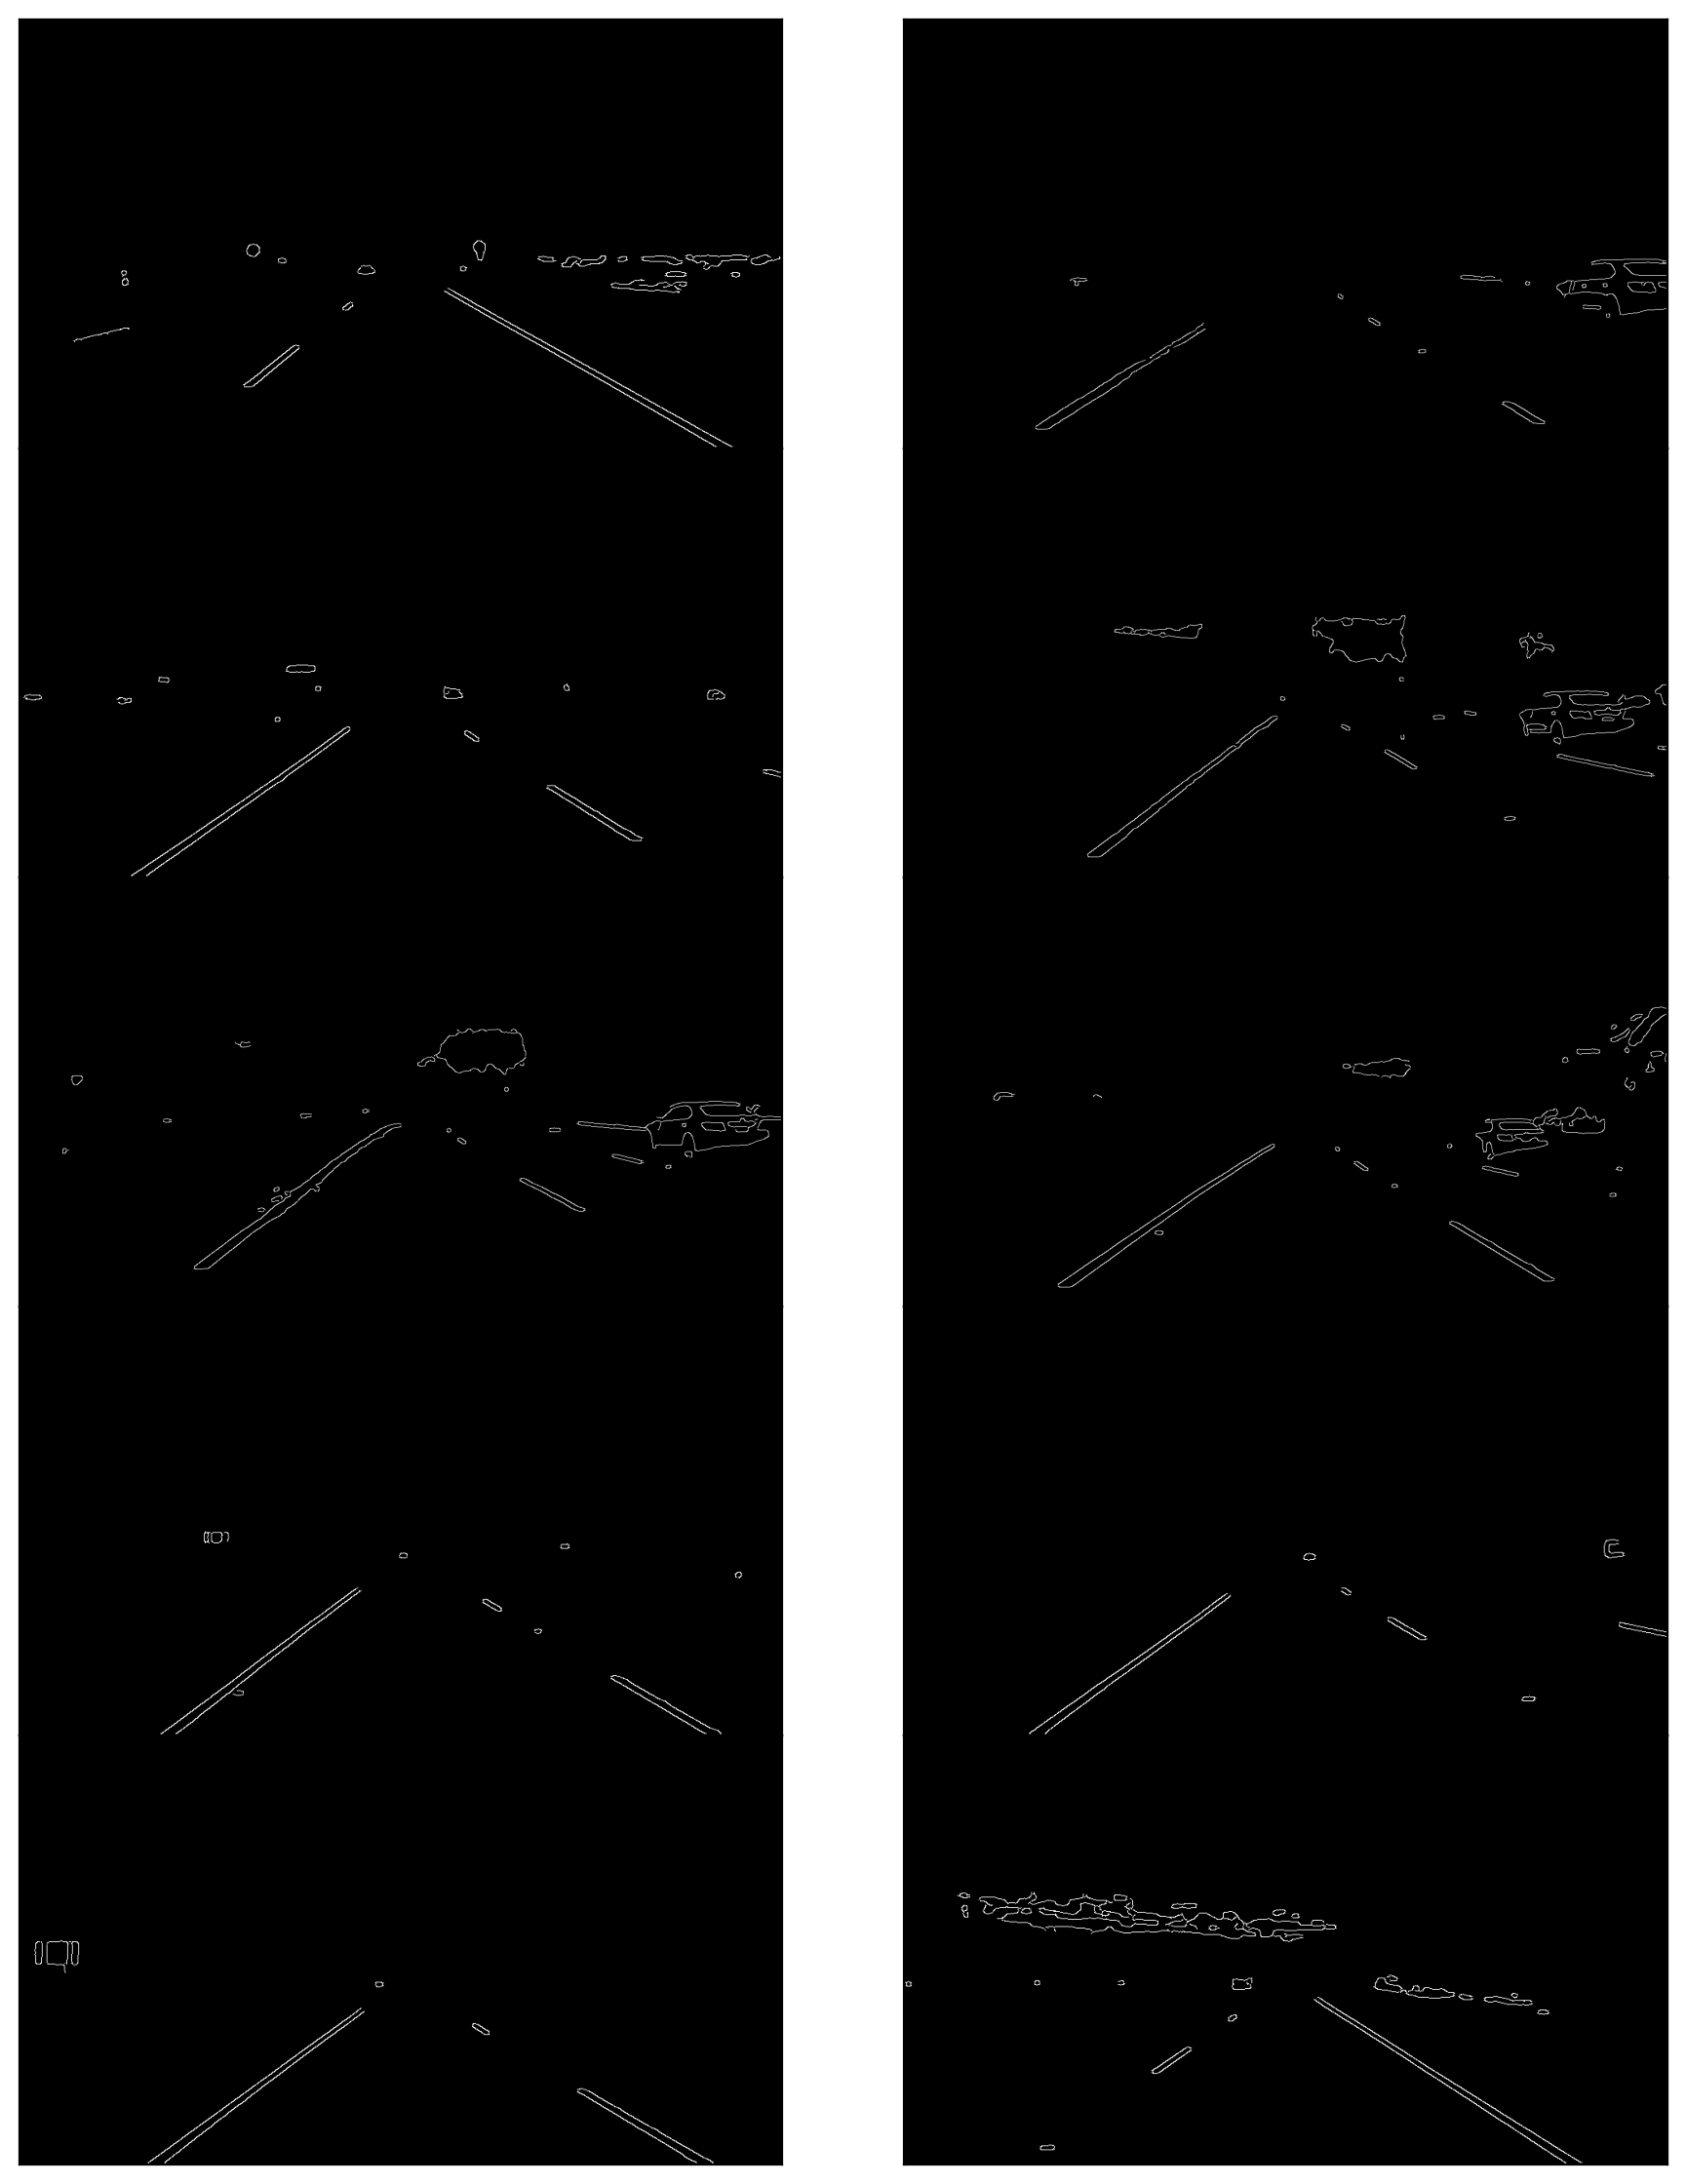

In [ ]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

## Region of Interest Selection

When finding lane lines, we don't need to check the sky and the hills.  

Roughly speaking, we are interested in the aread surrounded by the red lines below:

<img src='images/region-of-interest.png' width='50%'/>

So, we exclude outside the region of interest by apply a mask.

- [cv2.fillPoly OpenCV API Reference](http://docs.opencv.org/modules/core/doc/drawing_functions.html#fillpoly)

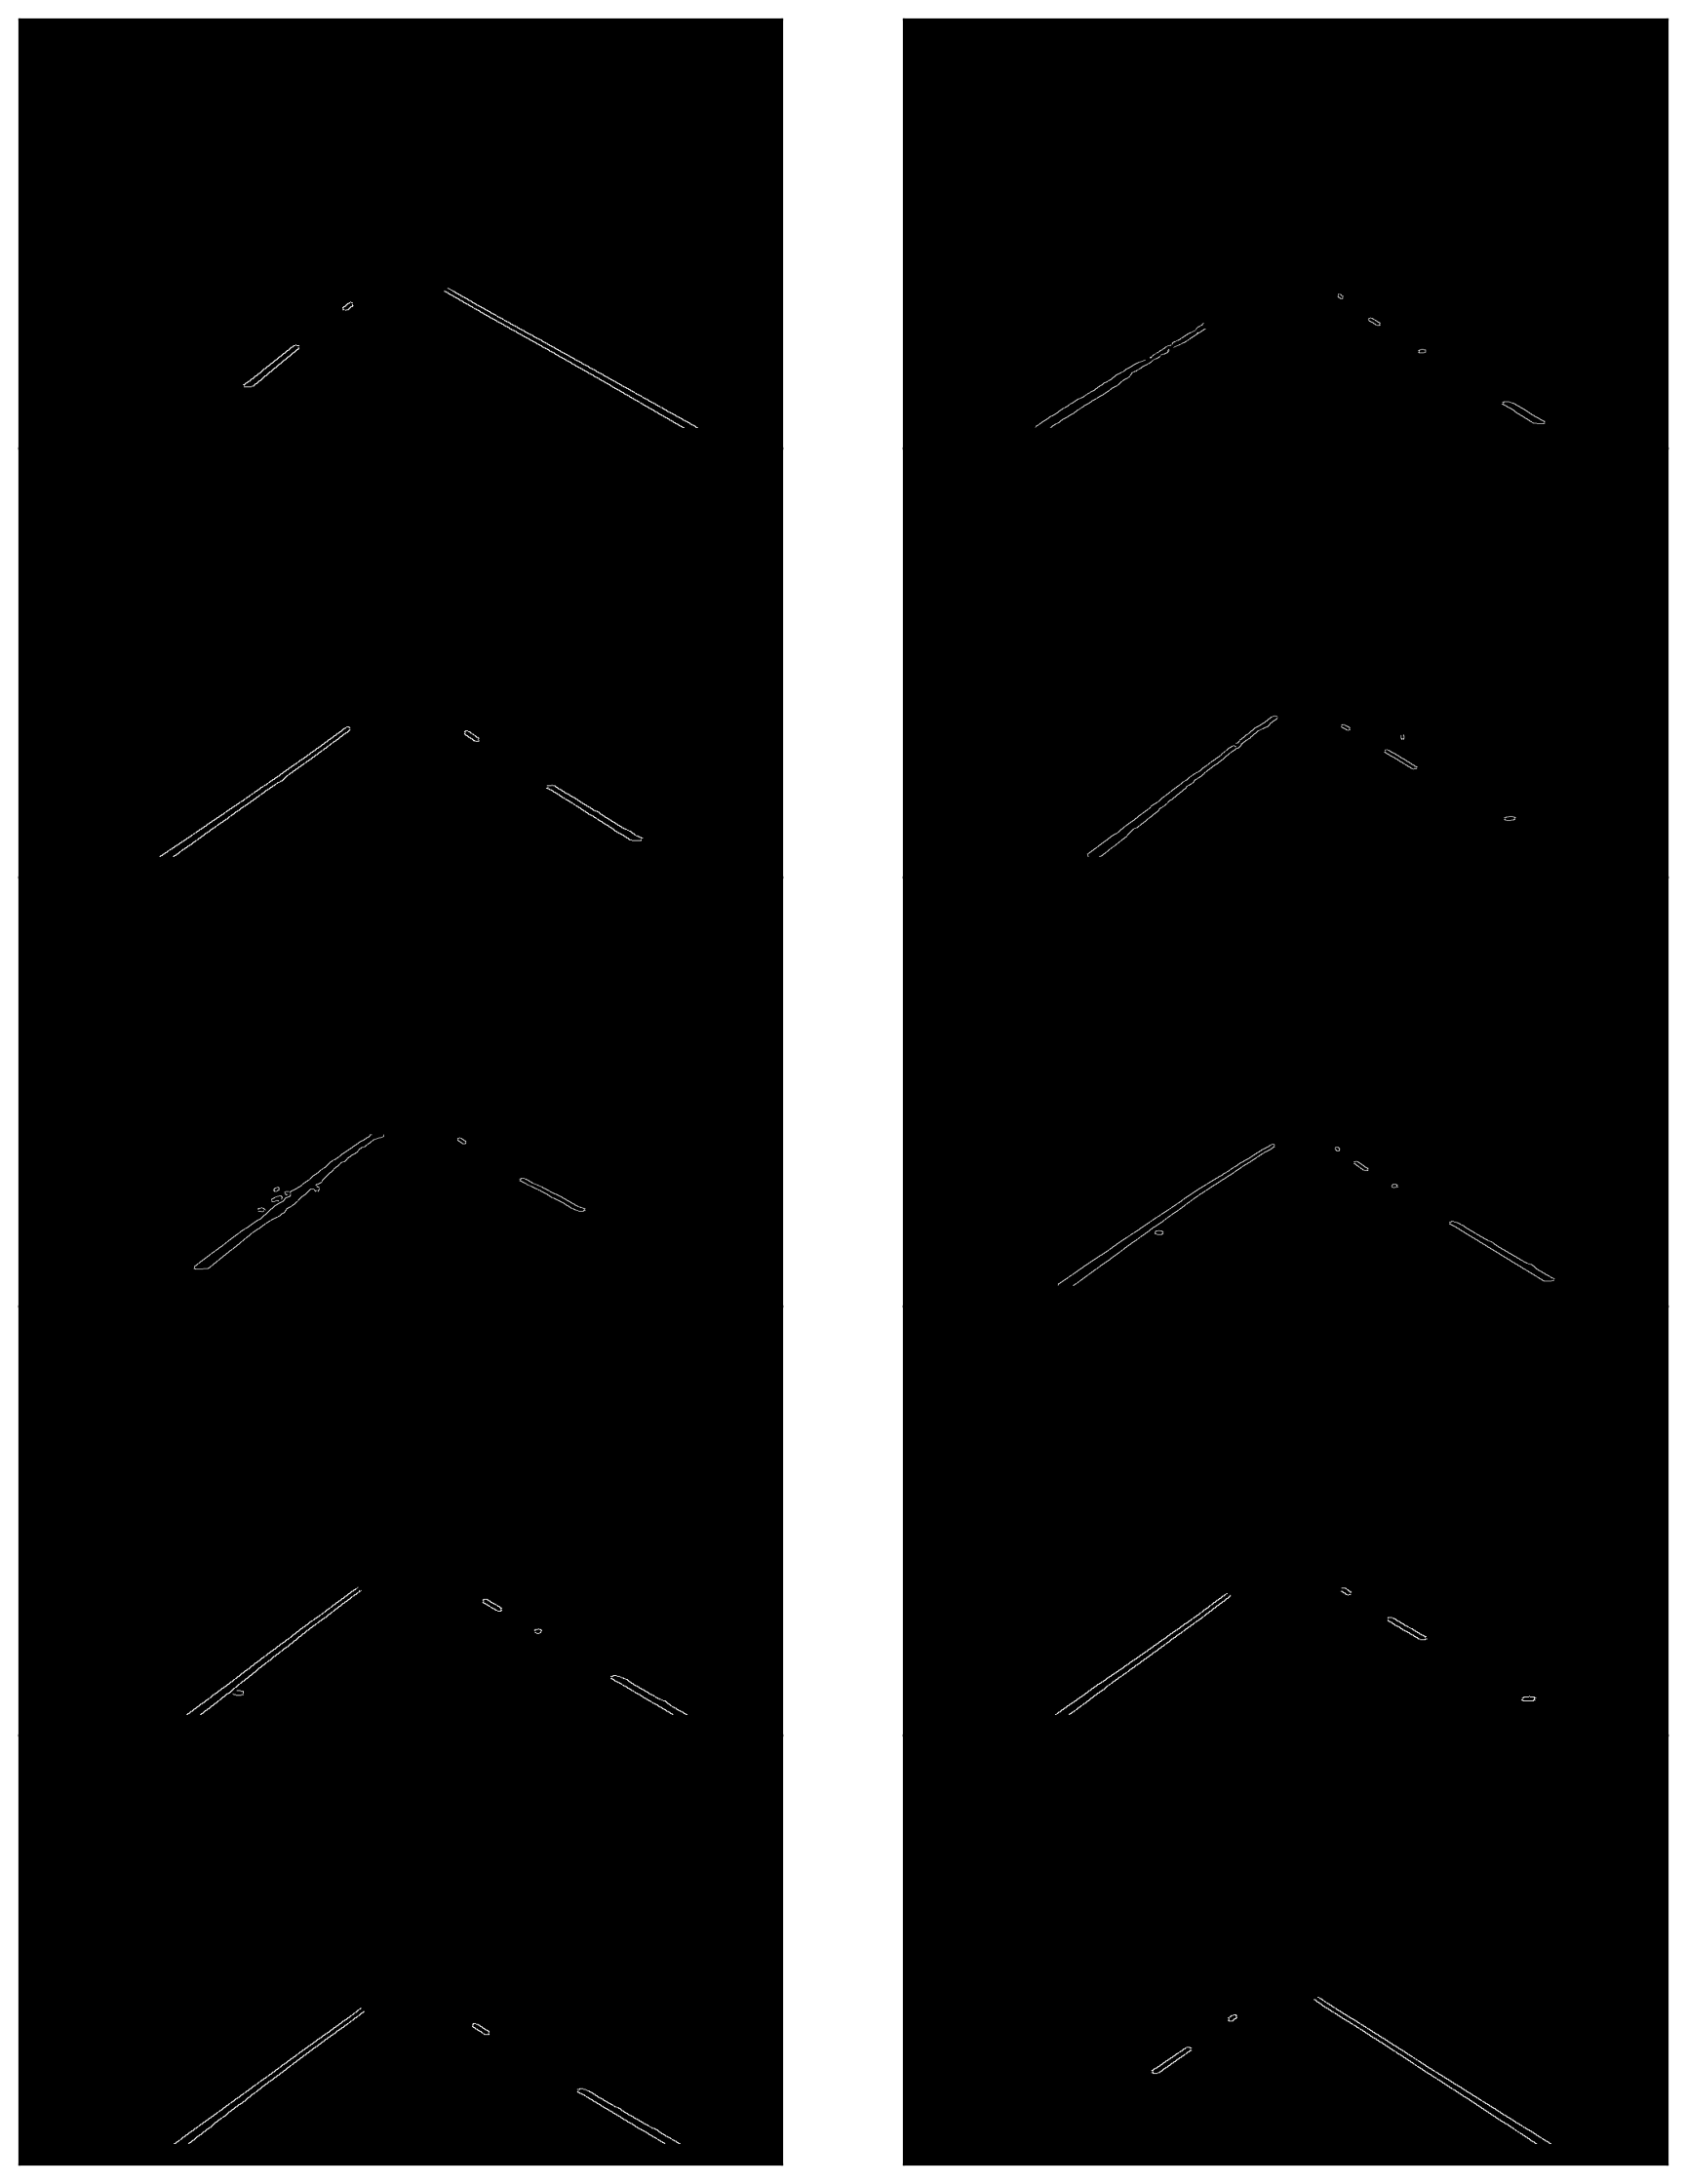

In [ ]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension
    return cv2.bitwise_and(image, mask)


def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

Now we have lane lines but we need to recognize them as lines.  Especially, two lines: the left lane and the right lane.

## Hough Transform Line Detection

I'm using `cv2.HoughLinesP` to detect lines in the edge images.

There are several parameters you'll need to tweak and tune:

- rho – Distance resolution of the accumulator in pixels.
- theta – Angle resolution of the accumulator in radians.
- threshold – Accumulator threshold parameter. Only those lines are returned that get enough votes (> `threshold`).
- minLineLength – Minimum line length. Line segments shorter than that are rejected.
- maxLineGap – Maximum allowed gap between points on the same line to link them.

More details can be found:

- [Hough Line Transform OpenCV Theory](http://docs.opencv.org/doc/tutorials/imgproc/imgtrans/hough_lines/hough_lines.html)
- [cv.HoughLinesP OpenCV API Reference](http://docs.opencv.org/modules/imgproc/doc/feature_detection.html?highlight=houghlinesp#houghlinesp)

In [ ]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.

    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

`list_of_lines` contains a list of lines detected.  With the above parameters, approximately 5-15 lines are detected for each image.

Let's draw the lines onto the original images.  

In [ ]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))

show_images(line_images)

### Averaging and Extrapolating Lines

There are multiple lines detected for a lane line.  We should come up with an averaged line for that.

Also, some lane lines are only partially recognized.  We should extrapolate the line to cover full lane line length.

We want two lane lines: one for the left and the other for the right.  The left lane should have a positive slope, and the right lane should have a negative slope.  Therefore, we'll collect positive slope lines and negative slope lines separately and take averages.

Note: in the image, `y` coordinate is reversed.  The higher `y` value is actually lower in the image.  Therefore, the slope is negative for the left lane, and the slope is positive for the right lane.

In [ ]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    # add more weight to longer lines
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None

    return left_lane, right_lane # (slope, intercept), (slope, intercept)

Using the above `average_lines` function, we can calculate average slope and intercept for the left and right lanes of each image.  

Let's draw the lanes.  I need to convert the slope and intercept into pixel points.

In [ ]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None

    slope, intercept = line

    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

Our `draw_lines` except a list of lines as the second parameter.  Each line is a list of 4 values (x1, y1, x2, y2).  The data type needs to be integer for `cv2.line` to work without throwing an error.

In [ ]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)

    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)

    return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)


lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))


show_images(lane_images)

## Video Clips

I'm drwaing lanes on video clips.

In [ ]:
from collections import deque

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        smooth_gray  = apply_smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return draw_lane_lines(image, (left_line, right_line))

Let's try the one with the solid white lane on the right first ...

In [ ]:
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('/content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('/content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos', video_output), audio=False)

In [ ]:
%time process_video('solidWhiteRight.mp4', 'white.mp4')

t:   1%|          | 2/221 [01:08<2:05:37, 34.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/white.mp4.
Moviepy - Writing video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/white.mp4




t:   1%|          | 2/221 [01:25<2:36:28, 42.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/white.mp4
CPU times: user 4.64 s, sys: 618 ms, total: 5.26 s
Wall time: 17 s


In [ ]:
%time process_video('solidYellowLeft.mp4', 'yellow.mp4')

t:   1%|          | 2/221 [01:25<2:36:46, 42.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/yellow.mp4.
Moviepy - Writing video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/yellow.mp4




t:   1%|          | 2/221 [02:17<4:11:20, 68.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/yellow.mp4
CPU times: user 14.6 s, sys: 1.82 s, total: 16.4 s
Wall time: 52 s


In [ ]:
%time process_video('challenge.mp4', 'extra.mp4')

t:   1%|          | 2/221 [02:19<4:13:41, 69.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/extra.mp4.
Moviepy - Writing video /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/extra.mp4




t:   1%|          | 2/221 [02:55<5:21:07, 87.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Colab Notebooks/computer vision/Project/car-finding-lane-lines-master/car-finding-lane-lines-master/output_videos/extra.mp4
CPU times: user 8.85 s, sys: 960 ms, total: 9.81 s
Wall time: 38.2 s


## Conclusion

The project was successful in that the video images clearly show the lane lines are detected properly and lines are very smoothly handled.

It only detects the straight lane lines.  It is an advanced topic to handle curved lanes (or the curvature of lanes).  We'll need to use perspective transformation and also poly fitting lane lines rather than fitting to straight lines.

Having said that, the lanes near the car are mostly straight in the images.  The curvature appears at further distance unless it's a steep curve.  So, this basic lane finding technique is still very useful.

Another thing is that it won't work for steep (up or down) roads because the region of interest mask is assumed from the center of the image.

For steep roads, we first need to detect the holizontal line (between the sky and the earth) so that we can tell up to where the lines should extend.